In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5
NUM_MODELS = 2  # We will use MobileNet and Inception models
NUM_ENSEMBLE_MEMBERS = 3  # Number of models in the ensemble

# Define directories
train_dir = '/content/drive/MyDrive/Lab/train'
test_dir = '/content/drive/MyDrive/Lab/test'
val_dir = '/content/drive/MyDrive/Lab/val'

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)


Found 5778 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [ ]:
# Load pre-trained models
base_models = [MobileNet(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights='imagenet'),
               InceptionV3(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights='imagenet')]


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Create ensemble members
ensemble_members = []
for i in range(NUM_ENSEMBLE_MEMBERS):
    for base_model in base_models:
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        predictions = Dense(NUM_CLASSES, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=predictions)
        ensemble_members.append(model)

In [ ]:
# Compile models
for model in ensemble_members:
    model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train models
for model in ensemble_members:
    model.fit(train_generator, epochs=5, validation_data=val_generator)


Epoch 1/5
181/181 [==============================] - 2110s 11s/step - loss: 1.2939 - accuracy: 0.4865 - val_loss: 1.4775 - val_accuracy: 0.3002
Epoch 2/5
181/181 [==============================] - 108s 599ms/step - loss: 1.0014 - accuracy: 0.5867 - val_loss: 1.0214 - val_accuracy: 0.5835
Epoch 3/5
181/181 [==============================] - 104s 574ms/step - loss: 0.9439 - accuracy: 0.6037 - val_loss: 0.9317 - val_accuracy: 0.6259
Epoch 4/5
181/181 [==============================] - 105s 579ms/step - loss: 0.9080 - accuracy: 0.6194 - val_loss: 1.0891 - val_accuracy: 0.5787
Epoch 5/5
181/181 [==============================] - 105s 579ms/step - loss: 0.9014 - accuracy: 0.6279 - val_loss: 0.9004 - val_accuracy: 0.6429
Epoch 1/5
181/181 [==============================] - 160s 667ms/step - loss: 1.3585 - accuracy: 0.4258 - val_loss: 2.9347 - val_accuracy: 0.4031
Epoch 2/5
181/181 [==============================] - 113s 624ms/step - loss: 1.1761 - accuracy: 0.5050 - val_loss: 4.9450 - val_acc

In [ ]:
# Make predictions
ensemble_predictions = []
for model in ensemble_members:
    predictions = model.predict(test_generator)
    ensemble_predictions.append(predictions)


52/52 [==============================] - 9s 150ms/step


In [ ]:
# Voting ensemble
ensemble_predictions = np.array(ensemble_predictions)
voting_predictions = np.argmax(np.sum(ensemble_predictions, axis=0), axis=1)

In [ ]:
# True labels
true_labels = test_generator.classes

# Calculate accuracy
ensemble_accuracy = accuracy_score(true_labels, voting_predictions)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.6763285024154589


Ensemble Accuracy: 0.6763285024154589
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.91      0.79       639
           1       0.34      0.04      0.07       296
           2       0.58      0.78      0.67       447
           3       0.88      0.64      0.74       223
           4       0.89      0.76      0.82        51

    accuracy                           0.68      1656
   macro avg       0.68      0.62      0.62      1656
weighted avg       0.64      0.68      0.62      1656

Confusion Matrix:
[[580   5  54   0   0]
 [161  11 124   0   0]
 [ 80  11 348   8   0]
 [  1   5  70 142   5]
 [  0   0   1  11  39]]


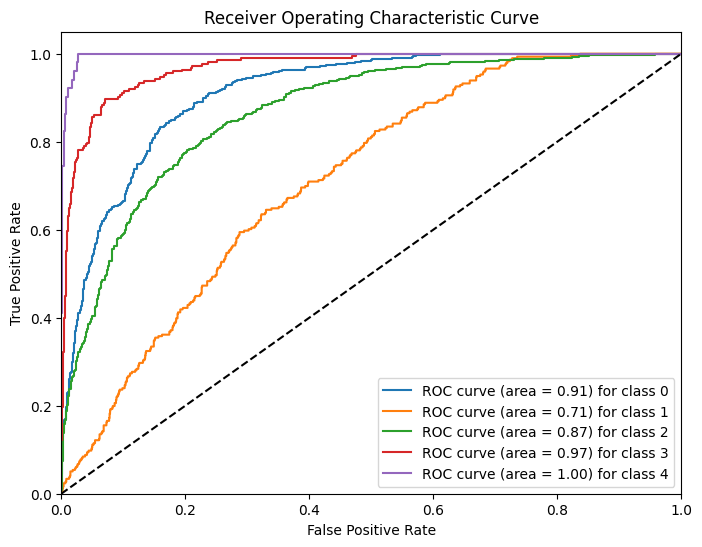

In [ ]:
# Calculate accuracy
ensemble_accuracy = accuracy_score(true_labels, voting_predictions)
print("Ensemble Accuracy:", ensemble_accuracy)

# Classification report
print("Classification Report:")
print(classification_report(true_labels, voting_predictions))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(true_labels, voting_predictions))

# AU-ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, ensemble_predictions[:, :, i].mean(axis=0))
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

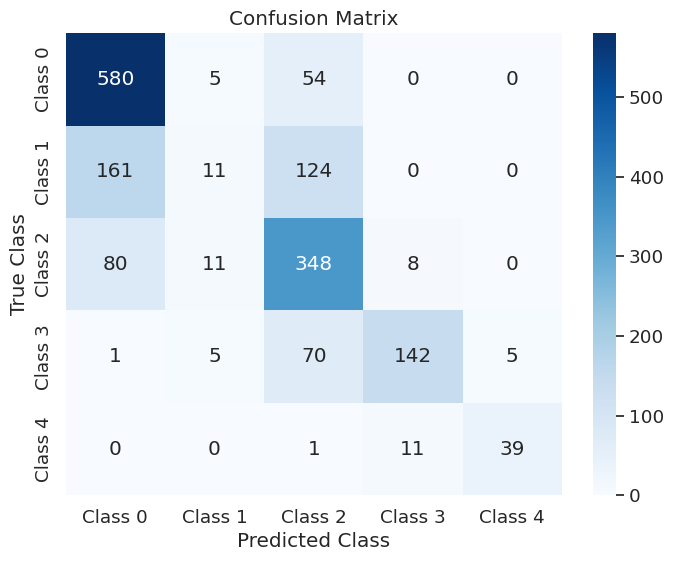

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the confusion matrix
conf_matrix = np.array([[580, 5, 54, 0, 0],
                        [161, 11, 124, 0, 0],
                        [80, 11, 348, 8, 0],
                        [1, 5, 70, 142, 5],
                        [0, 0, 1, 11, 39]])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"],
            yticklabels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()
